<a href="https://colab.research.google.com/github/LongNguyen1984/TimeSeriesWithPython/blob/main/ValidationTest_CrossValaditaion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Hitters.csv', header=0)

# Drop any rows the contain missing values, along with the player names
df = df.dropna().drop('Unnamed: 0', axis=1)

#Get dummy variable
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])

# Extract independent variable
y = pd.DataFrame(df.Salary)

# Drop the column with the independent variable (Salary), and columns for which we created dummy varibales
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)



In [3]:
dummies.head()

,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,0,1,0,1,0,1
2,1,0,0,1,1,0
3,0,1,1,0,0,1
4,0,1,1,0,0,1
5,1,0,0,1,1,0


In [4]:
df.head(20)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.000,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.000,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.000,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.500,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.000,A
6,185,37,1,23,8,21,2,214,42,1,30,9,24,N,E,76,127,7,70.000,A
7,298,73,0,24,24,7,3,509,108,0,41,37,12,A,W,121,283,9,100.000,A
8,323,81,6,26,32,8,2,341,86,6,32,34,8,N,W,143,290,19,75.000,N
9,401,92,17,49,66,65,13,5206,1332,253,784,890,866,A,E,0,0,0,1100.000,A
10,574,159,21,107,75,59,10,4631,1300,90,702,504,488,A,E,238,445,22,517.143,A


In [3]:
np.random.seed(seed=12)
train = np.random.choice([True, False], size = len(y), replace = True)
test = np.invert(train)

In [ ]:
train,test

In [4]:
def processSubset(feature_set, X_train, y_train, X_test, y_test):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y_train,X_train[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X_test[list(feature_set)]) - y_test) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [12]:
a = [2,4,5]
a + [2]

[2, 4, 5, 2]

In [5]:
def forward(predictors, X_train, y_train, X_test, y_test):
    
    results = []

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X_train.columns if p not in predictors]
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p], X_train, y_train, X_test, y_test))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
        
    # Return the best model, along with some other useful information about the model
    return best_model

In [6]:
models_train = pd.DataFrame(columns=["RSS", "model"])

predictors = []

for i in range(1,len(X.columns)+1):    
    models_train.loc[i] = forward(predictors, X[train], y[train]["Salary"], X[test], y[test]["Salary"])
    predictors = models_train.loc[i]["model"].model.exog_names

In [40]:
models_train.loc[2]["model"].model.exog_names

['Walks', 'CRBI']

In [8]:
models_train["RSS"].argmin()

9

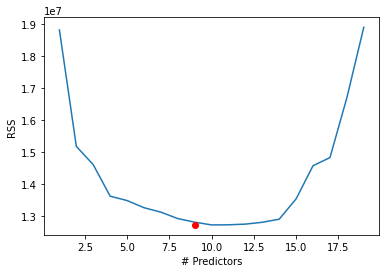

In [7]:
plt.plot(models_train["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')
plt.plot(models_train["RSS"].argmin(), models_train["RSS"].min(), "or")

In [12]:
models_test = pd.DataFrame(columns=["RSS", "model"])

predictors = []

for i in range(1,len(X.columns)+1): #11   
    models_test.loc[i] = forward(predictors, X[test], y[test]["Salary"], X[test], y[test]["Salary"])
    predictors = models_test.loc[i]["model"].model.exog_names

In [18]:
print(models_train.loc[10, "model"].model.exog_names)
print(models_test.loc[18, "model"].model.exog_names)

['Walks', 'CRBI', 'Hits', 'Division_W', 'CWalks', 'CRuns', 'AtBat', 'League_N', 'CHits', 'Runs']
['Walks', 'CRBI', 'Assists', 'Division_W', 'CWalks', 'CRuns', 'PutOuts', 'Errors', 'League_N', 'CHmRun', 'NewLeague_N', 'AtBat', 'Hits', 'CAtBat', 'CHits', 'Runs', 'RBI', 'HmRun']


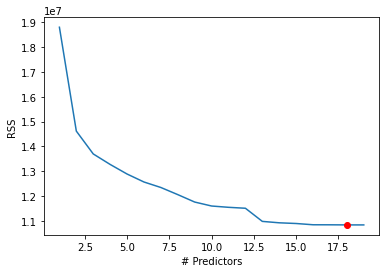

In [17]:
plt.plot(models_test["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')
plt.plot(models_test["RSS"].argmin(), models_test["RSS"].min(),'or')

##Model selection using Cross-Validation

In [19]:
k = 10        # number of folds
np.random.seed(seed=1)
folds = np.random.choice(k, size = len(y), replace = True)

# Create a DataFrame to store the results of our upcoming calculations
cv_errors = pd.DataFrame(columns=range(1,k+1), index=range(1,20))
cv_errors = cv_errors.fillna(0)

(array([32., 23., 23., 26., 26., 20., 25., 35., 53.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

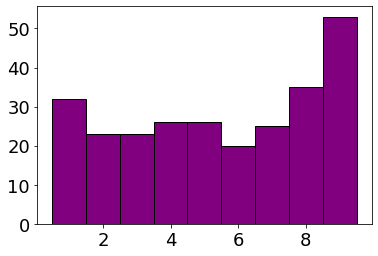

In [43]:
df_folds = pd.DataFrame(folds)
df_folds.describe()
plt.hist(folds, bins=range(0,10,1), align='right', color='purple', edgecolor='black')

In [24]:
models_cv = pd.DataFrame(columns=["RSS", "model"])
    
# Outer loop iterates over all folds
for j in range(1,k+1):

    # Reset predictors
    predictors = []
    
    # Inner loop iterates over each size i
    for i in range(1,len(X.columns)+1):    
    
        # The perform forward selection on the full dataset minus the jth fold, test on jth fold
        models_cv.loc[i] = forward(predictors, X[folds != (j-1)], y[folds != (j-1)]["Salary"], X[folds == (j-1)], y[folds == (j-1)]["Salary"])
        
        # Save the cross-validated error for this fold
        cv_errors[j][i] = models_cv.loc[i]["RSS"]

        # Extract the predictors
        predictors = models_cv.loc[i]["model"].model.exog_names

In [25]:
cv_errors

,1,2,3,4,5,6,7,8,9,10
1,3107900,3212304,4840103,2475453,3750302,1551976,1827366,9115194,1370720,2204862
2,2354036,2247881,3414444,1642455,3160950,1250564,1567469,8520751,1081052,1856304
3,2148733,2012864,3009435,1566581,2775618,907304,1260460,8456576,969784,1674333
4,1946031,1870511,2630784,1521525,2618750,805135,1143882,8331746,857553,1618265
5,1850398,1605148,2537690,1502728,2608466,776171,1124174,8221957,793919,1574253
6,1778324,1574266,2498621,1482575,2632055,776163,1115741,8196969,781235,1534220
7,1761111,1524413,2452303,1480345,2661104,779716,1104388,8171959,776457,1503831
8,1733230,1529625,2418943,1477510,2660654,803859,1100753,7449396,774589,1536790
9,1773705,1607919,2381843,1504519,2677002,821629,1096925,7136283,774616,1542746
10,1865909,1682293,2378624,1528102,2597881,854997,1136162,7059485,775993,1597314


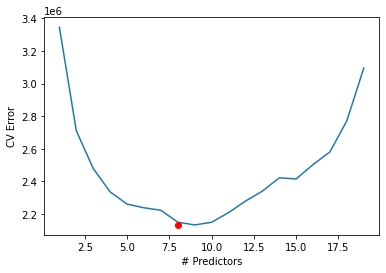

In [26]:
cv_mean = cv_errors.apply(np.mean, axis=1)

plt.plot(cv_mean)
plt.xlabel('# Predictors')
plt.ylabel('CV Error')
plt.plot(cv_mean.argmin(), cv_mean.min(), "or")

In [28]:
print(models_cv.loc[8, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.681
Model:                            OLS   Adj. R-squared (uncentered):              0.670
Method:                 Least Squares   F-statistic:                              60.60
Date:                Fri, 21 May 2021   Prob (F-statistic):                    3.83e-52
Time:                        08:21:45   Log-Likelihood:                         -1739.3
No. Observations:                 235   AIC:                                      3495.
Df Residuals:                     227   BIC:                                      3522.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Text(0, 0.5, 'BIC')

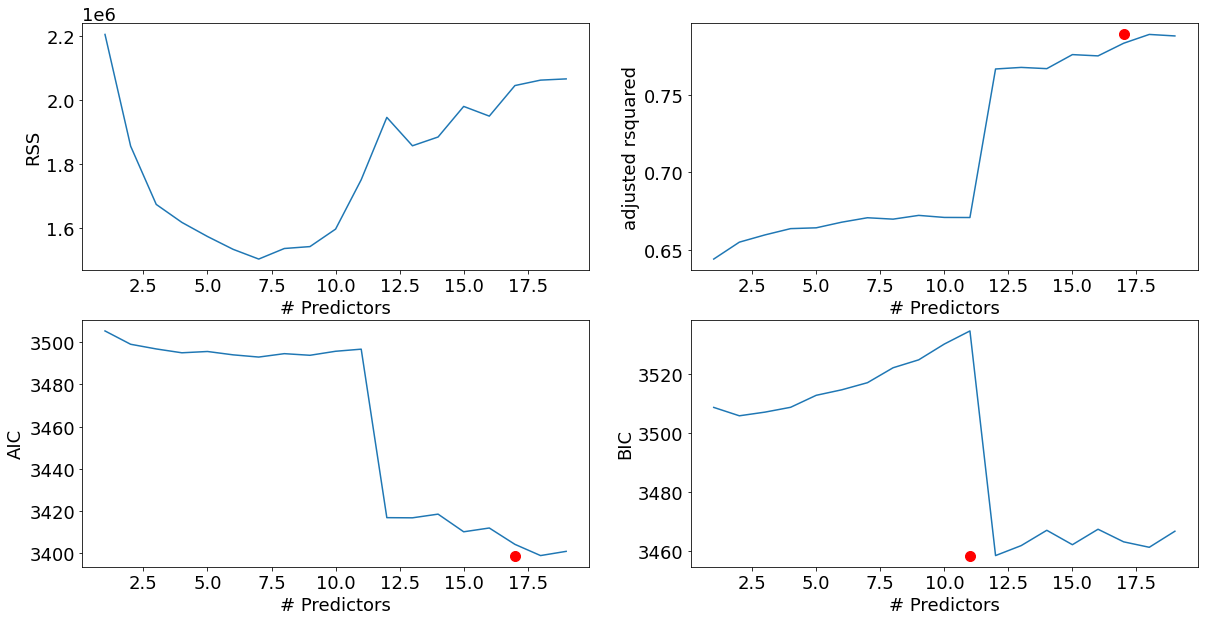

In [29]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_cv["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_cv.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_cv.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_cv.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

## Lambda function example

In [57]:
bic

1     3508.762076
2     3505.913477
3     3507.160868
4     3508.798829
5     3512.871923
6     3514.747208
7     3517.155199
8     3522.225200
9     3524.916995
10    3530.276743
11    3534.731728
12    3458.444073
13    3461.824543
14    3467.030663
15    3462.134447
16    3467.384436
17    3463.107163
18    3461.256882
19    3466.709310
dtype: float64

In [61]:
models_cv["model"]

1     <statsmodels.regression.linear_model.Regressio...
2     <statsmodels.regression.linear_model.Regressio...
3     <statsmodels.regression.linear_model.Regressio...
4     <statsmodels.regression.linear_model.Regressio...
5     <statsmodels.regression.linear_model.Regressio...
6     <statsmodels.regression.linear_model.Regressio...
7     <statsmodels.regression.linear_model.Regressio...
8     <statsmodels.regression.linear_model.Regressio...
9     <statsmodels.regression.linear_model.Regressio...
10    <statsmodels.regression.linear_model.Regressio...
11    <statsmodels.regression.linear_model.Regressio...
12    <statsmodels.regression.linear_model.Regressio...
13    <statsmodels.regression.linear_model.Regressio...
14    <statsmodels.regression.linear_model.Regressio...
15    <statsmodels.regression.linear_model.Regressio...
16    <statsmodels.regression.linear_model.Regressio...
17    <statsmodels.regression.linear_model.Regressio...
18    <statsmodels.regression.linear_model.Regre

In [46]:
identity(5)

5

In [51]:
sum = lambda x,y: x+y

In [53]:
(lambda x: (x%2 and 'odd' or 'even'))(4)

'even'

In [55]:
0 and 'even'

0